In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import cv2
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from glob import glob

from collections import OrderedDict
import torch
import gc

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
!deactivate

# Install CLIP library

In [5]:
!pip install ./openaiclipweights/python-ftfy-master/python-ftfy-master
!pip install ./openaiclipweights/clip/CLIP
!cp ./openaiclipweights/CLIP-main/CLIP-main/clip/bpe_simple_vocab_16e6.txt ../.venv/Lib/site-packages/clip/.
!gzip -k ../.venv/Lib/site-packages/clip/bpe_simple_vocab_16e6.txt
!ls ../.venv/Lib/site-packages/clip/bpe_simple_vocab_16e6.txt

Processing d:\webrtc_humananatomy\clip\openaiclipweights\python-ftfy-master\python-ftfy-master
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for ftfy: filename=ftfy-6.0.2-py3-none-any.whl size=41953 sha256=f4236ccfb29a8dec6a4982a9062bb883372efdad06db5f22fad2573cb4d60a04
  Stored in directory: c:\users\bryan\appdata\local\pip\cache\wheels\79\8c\4f\f15a96064a60f620ae629d512ad402b1bb970b361755eaadf1
Successfully built ftfy
  Attempting uninstall: ftfy
    Found existing installation: ftfy 6.0.2
    Uninstalling ftfy-6.0.2:
      Successfully uninstalled ftfy-6.0.2
Processing d:\webrtc_humananatomy\clip\openaiclipweights\clip\clip
  Installing build dependencies: started
  Installing build depen

'cp' is not recognized as an internal or external command,
operable program or batch file.
'gzip' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
import torch
import clip
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset

print("Torch version:", torch.__version__)

Torch version: 2.4.0+cpu


# Download some images from open images collection.

In [11]:
import wget

# List of URLs to download
urls = [
    "https://farm8.staticflickr.com/6036/6426668771_b5b915e46c_o.jpg",
    "https://c6.staticflickr.com/8/7457/10806045045_02d3dbdcee_o.jpg",
    "https://c1.staticflickr.com/4/3267/2888764405_0a0a608604_o.jpg",
    "https://farm8.staticflickr.com/4028/4294212194_a49663b2b9_o.jpg",
    "https://c5.staticflickr.com/9/8173/8019508216_6540c8686a_o.jpg",
    "https://farm3.staticflickr.com/1146/1357102390_943c5cb999_o.jpg"
]

# Loop through the URLs and download each file
for url in urls:
    wget.download(url)


In [45]:
files = glob('*.jpeg')
files += glob('*.jpg')
print(files)

['sdfngbje.jpeg', '10806045045_02d3dbdcee_o.jpg', '1357102390_943c5cb999_o.jpg', '2888764405_0a0a608604_o.jpg', '4294212194_a49663b2b9_o.jpg', '484757150-612x612.jpg', '6426668771_b5b915e46c_o.jpg', '8019508216_6540c8686a_o.jpg']


# List pretrained CLIP models available

In [13]:
clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

# List pretrained weights available

In [14]:
!ls ./openaiclipweights/clip/CLIP/models/

'ls' is not recognized as an internal or external command,
operable program or batch file.


# Load CLIP Vision Transformer based model

In [17]:
model, preprocess = clip.load("./openaiclipweights/clip/CLIP/models/ViT-B-32.pt")
model.cpu().eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

# For each image we will query for the following sentences and see what CLIP predicts. 
# You can add custom sentences here.

In [38]:
QUERIES = [
    "a dog",
    "a cat",
    "a elephant",
    "a zebra",
    "a sleeping dog",
    "a sleeping cat",
    "a giraffe",
    "a poodle",
    "animal inside a car",
    "animal outside a car",
    "a sofa",
    "some animals",
    "santa claus",
    "ipod",
    "two mugs",
    "three mugs",
    "blue sky",
    "brain_scan",
    "brain",
    "human",
    "baldur's gate",
    "knight",
    "blue hair",
    "game"
]


# Score images vs queries using clip model

sdfngbje.jpeg


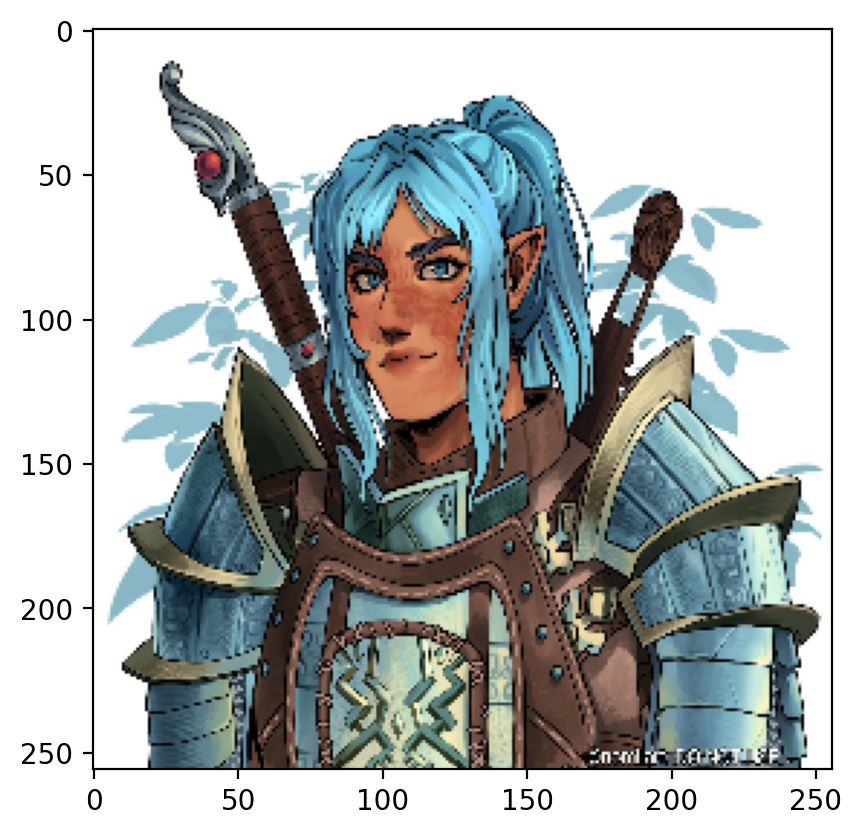

C:\Users\bryan\AppData\Local\Temp\ipykernel_20644\2784439362.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sc = float((image_embeddings @ text_embeddings.T).numpy())  # Remove .cpu()


                   query     score
21                knight  0.241885
22             blue hair  0.237754
20         baldur's gate  0.227469
23                  game  0.218725
19                 human  0.216180
0                  a dog  0.215503
16              blue sky  0.213840
1                  a cat  0.213145
7               a poodle  0.206014
6              a giraffe  0.204729
15            three mugs  0.203359
14              two mugs  0.200871
2             a elephant  0.200701
18                 brain  0.199290
13                  ipod  0.193179
12           santa claus  0.186933
11          some animals  0.182391
17            brain_scan  0.179969
3                a zebra  0.178773
10                a sofa  0.178353
5         a sleeping cat  0.162022
4         a sleeping dog  0.161996
9   animal outside a car  0.150143
8    animal inside a car  0.148832

-------------------------

10806045045_02d3dbdcee_o.jpg


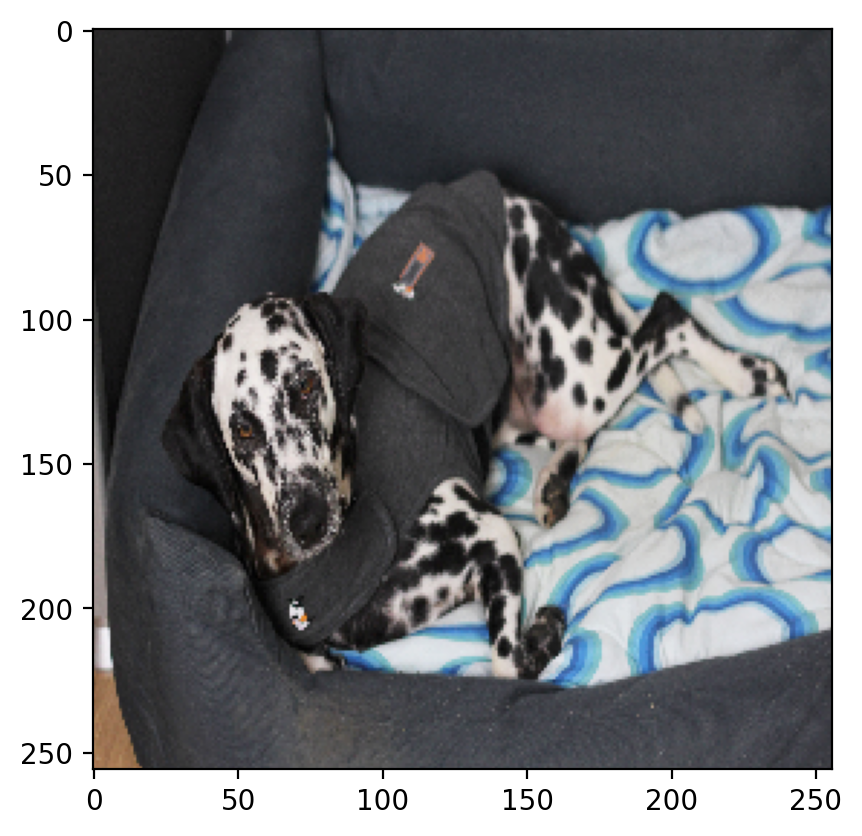

C:\Users\bryan\AppData\Local\Temp\ipykernel_20644\2784439362.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sc = float((image_embeddings @ text_embeddings.T).numpy())  # Remove .cpu()


                   query     score
4         a sleeping dog  0.257170
0                  a dog  0.235859
10                a sofa  0.219227
7               a poodle  0.216318
19                 human  0.207951
8    animal inside a car  0.205284
6              a giraffe  0.204216
3                a zebra  0.199958
5         a sleeping cat  0.198990
21                knight  0.196015
2             a elephant  0.194563
20         baldur's gate  0.194290
9   animal outside a car  0.190799
18                 brain  0.190169
13                  ipod  0.188368
17            brain_scan  0.184391
1                  a cat  0.183529
11          some animals  0.183204
12           santa claus  0.181980
16              blue sky  0.181798
23                  game  0.180770
22             blue hair  0.166102
14              two mugs  0.164840
15            three mugs  0.161746

-------------------------

1357102390_943c5cb999_o.jpg


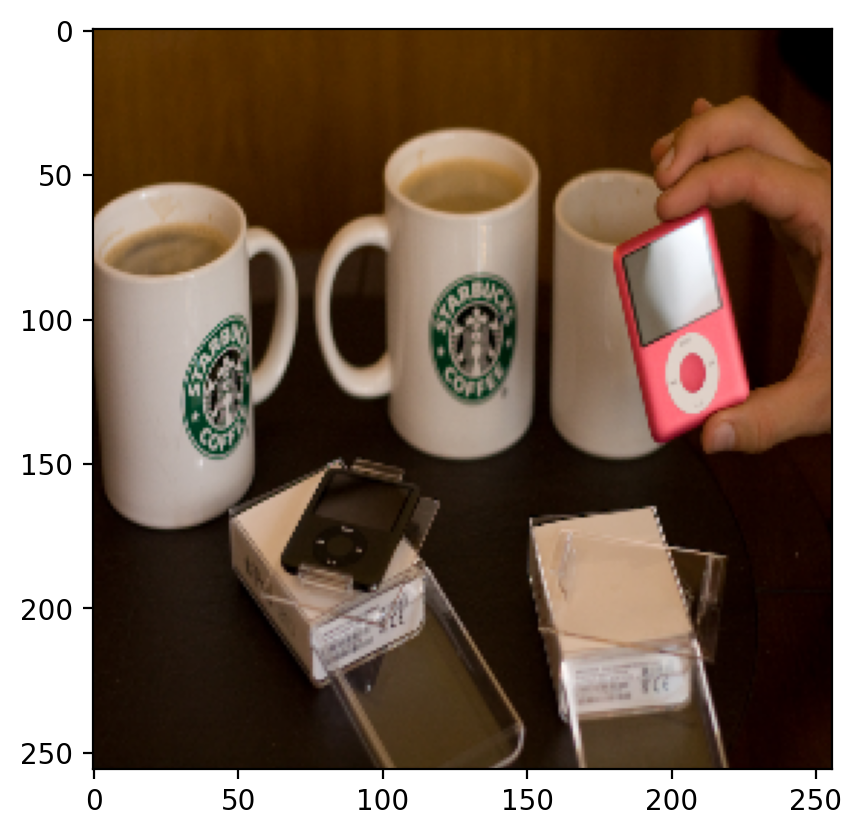

C:\Users\bryan\AppData\Local\Temp\ipykernel_20644\2784439362.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sc = float((image_embeddings @ text_embeddings.T).numpy())  # Remove .cpu()


                   query     score
15            three mugs  0.246304
14              two mugs  0.233707
13                  ipod  0.221407
17            brain_scan  0.196601
19                 human  0.191489
23                  game  0.188001
18                 brain  0.183358
20         baldur's gate  0.183230
10                a sofa  0.180313
11          some animals  0.172786
12           santa claus  0.171190
2             a elephant  0.164600
16              blue sky  0.157637
6              a giraffe  0.156587
3                a zebra  0.152199
21                knight  0.151813
1                  a cat  0.148473
0                  a dog  0.148076
8    animal inside a car  0.142979
22             blue hair  0.138387
9   animal outside a car  0.138361
7               a poodle  0.137400
5         a sleeping cat  0.136979
4         a sleeping dog  0.135420

-------------------------

2888764405_0a0a608604_o.jpg


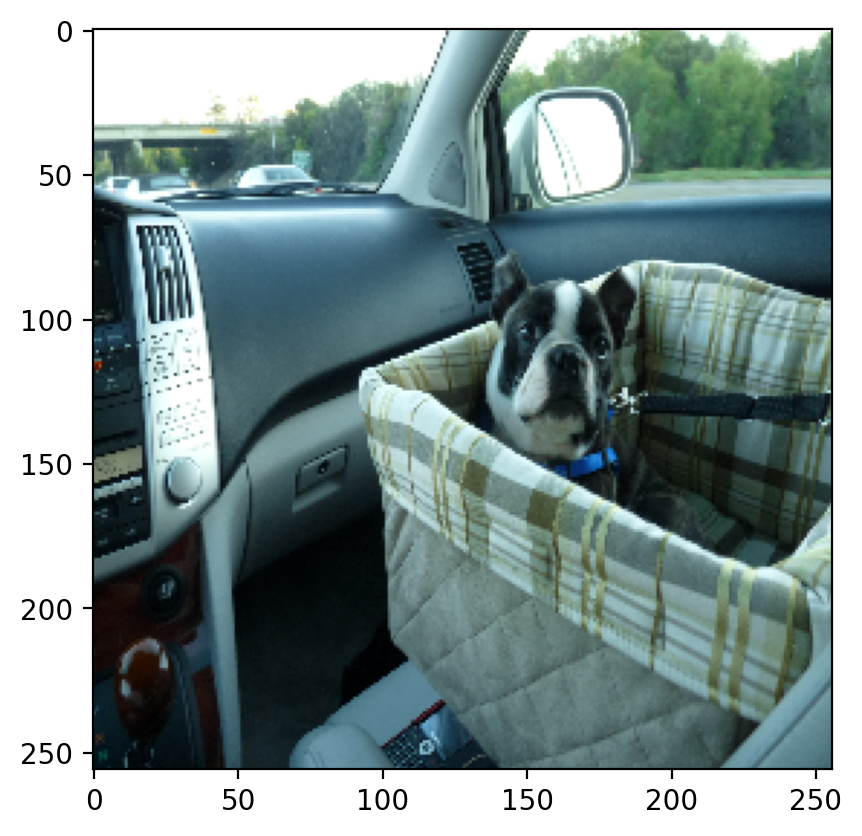

C:\Users\bryan\AppData\Local\Temp\ipykernel_20644\2784439362.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sc = float((image_embeddings @ text_embeddings.T).numpy())  # Remove .cpu()


                   query     score
8    animal inside a car  0.267413
9   animal outside a car  0.249769
4         a sleeping dog  0.243821
0                  a dog  0.238777
10                a sofa  0.228614
19                 human  0.210506
7               a poodle  0.206428
13                  ipod  0.206101
11          some animals  0.192508
3                a zebra  0.191841
17            brain_scan  0.188970
5         a sleeping cat  0.188710
1                  a cat  0.188481
21                knight  0.186233
18                 brain  0.184737
6              a giraffe  0.184534
23                  game  0.183674
14              two mugs  0.177863
16              blue sky  0.177291
2             a elephant  0.176541
15            three mugs  0.172379
12           santa claus  0.168804
20         baldur's gate  0.163421
22             blue hair  0.163105

-------------------------

4294212194_a49663b2b9_o.jpg


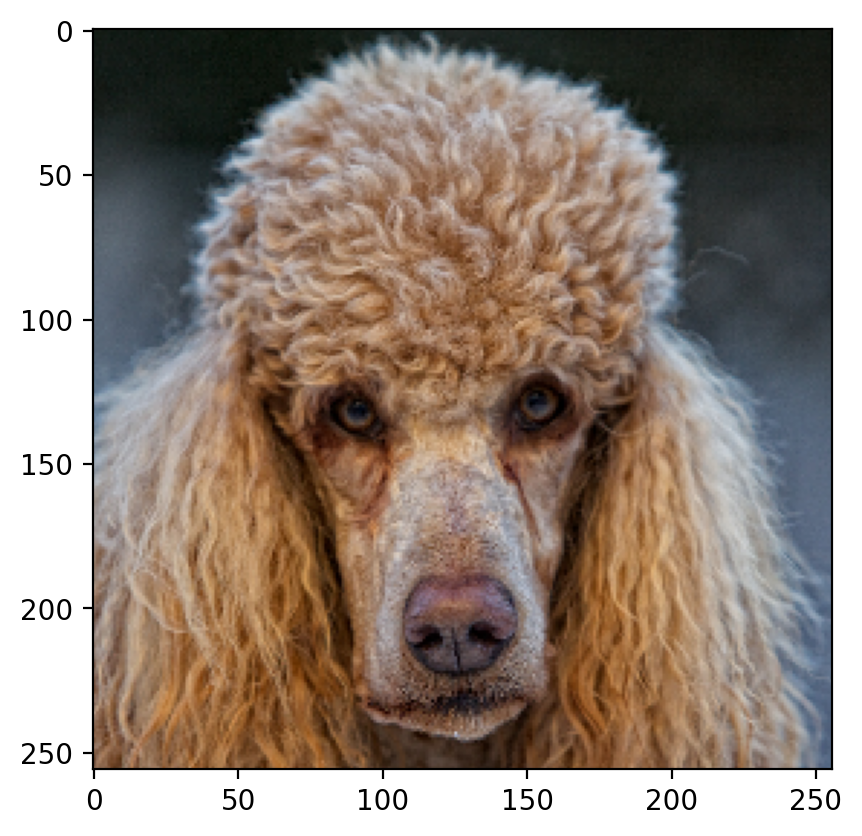

C:\Users\bryan\AppData\Local\Temp\ipykernel_20644\2784439362.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sc = float((image_embeddings @ text_embeddings.T).numpy())  # Remove .cpu()


                   query     score
7               a poodle  0.290736
0                  a dog  0.261174
9   animal outside a car  0.231913
8    animal inside a car  0.220457
19                 human  0.219235
20         baldur's gate  0.209682
4         a sleeping dog  0.209034
13                  ipod  0.207910
11          some animals  0.207527
6              a giraffe  0.207209
1                  a cat  0.205292
18                 brain  0.204298
2             a elephant  0.198162
17            brain_scan  0.195507
12           santa claus  0.195102
10                a sofa  0.193376
23                  game  0.190290
3                a zebra  0.181186
21                knight  0.181089
15            three mugs  0.176478
14              two mugs  0.173084
16              blue sky  0.171639
22             blue hair  0.164062
5         a sleeping cat  0.155552

-------------------------

484757150-612x612.jpg


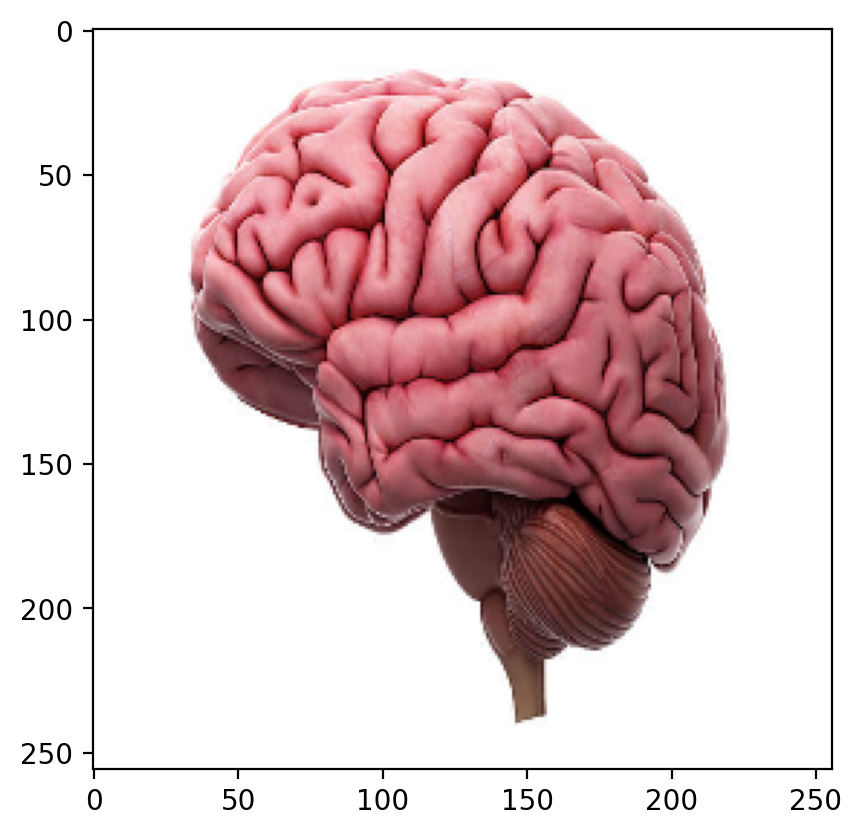

C:\Users\bryan\AppData\Local\Temp\ipykernel_20644\2784439362.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sc = float((image_embeddings @ text_embeddings.T).numpy())  # Remove .cpu()


                   query     score
18                 brain  0.287204
17            brain_scan  0.286000
19                 human  0.230733
10                a sofa  0.204542
2             a elephant  0.198292
3                a zebra  0.192576
7               a poodle  0.189989
6              a giraffe  0.187541
23                  game  0.187066
8    animal inside a car  0.187044
0                  a dog  0.184592
12           santa claus  0.182420
1                  a cat  0.182144
11          some animals  0.181380
5         a sleeping cat  0.177758
14              two mugs  0.177707
22             blue hair  0.177606
4         a sleeping dog  0.176236
9   animal outside a car  0.172204
21                knight  0.171221
15            three mugs  0.171065
20         baldur's gate  0.169638
13                  ipod  0.164763
16              blue sky  0.159399

-------------------------

6426668771_b5b915e46c_o.jpg


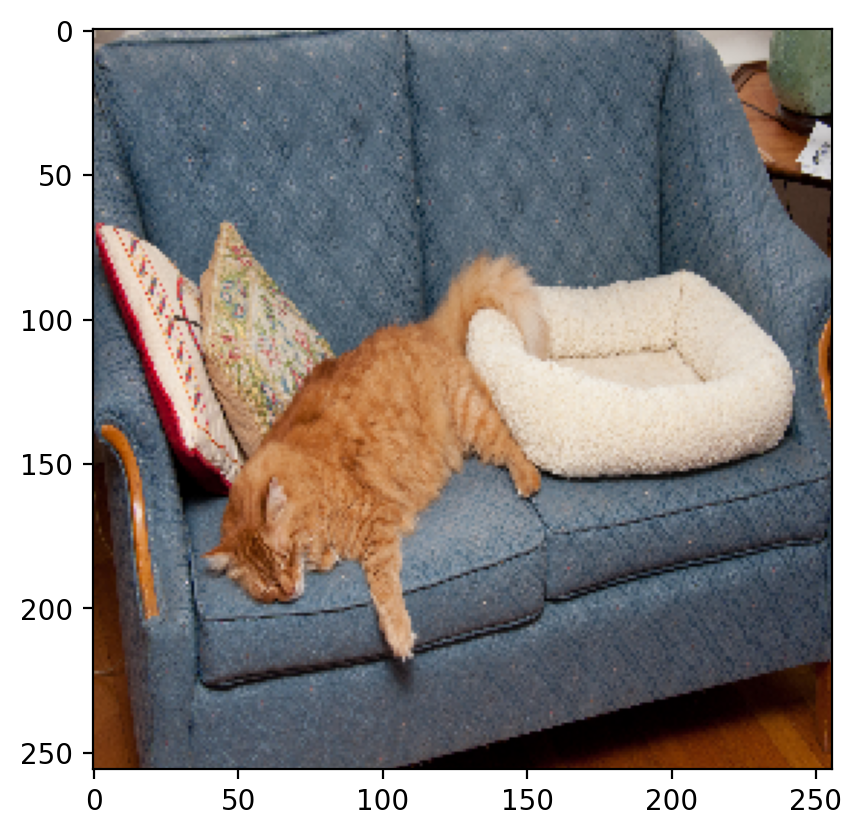

C:\Users\bryan\AppData\Local\Temp\ipykernel_20644\2784439362.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sc = float((image_embeddings @ text_embeddings.T).numpy())  # Remove .cpu()


                   query     score
10                a sofa  0.268308
5         a sleeping cat  0.259172
1                  a cat  0.237221
4         a sleeping dog  0.222800
19                 human  0.208856
0                  a dog  0.203094
14              two mugs  0.197236
11          some animals  0.197213
17            brain_scan  0.194914
7               a poodle  0.194241
15            three mugs  0.193678
6              a giraffe  0.188416
13                  ipod  0.187095
8    animal inside a car  0.181380
18                 brain  0.179666
2             a elephant  0.179122
21                knight  0.178789
23                  game  0.178722
12           santa claus  0.178221
20         baldur's gate  0.174042
9   animal outside a car  0.173050
3                a zebra  0.167796
16              blue sky  0.149083
22             blue hair  0.138845

-------------------------

8019508216_6540c8686a_o.jpg


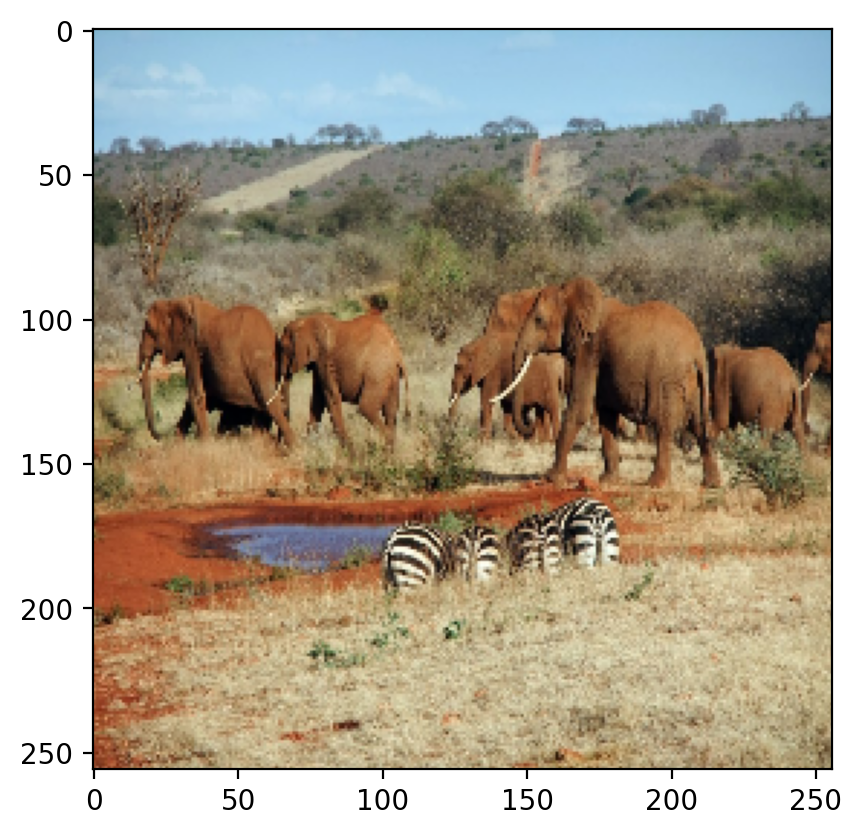

C:\Users\bryan\AppData\Local\Temp\ipykernel_20644\2784439362.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sc = float((image_embeddings @ text_embeddings.T).numpy())  # Remove .cpu()


                   query     score
2             a elephant  0.257968
3                a zebra  0.249207
11          some animals  0.242910
6              a giraffe  0.224228
9   animal outside a car  0.220036
8    animal inside a car  0.192351
15            three mugs  0.188101
16              blue sky  0.180108
23                  game  0.178911
19                 human  0.177289
13                  ipod  0.176462
14              two mugs  0.175491
10                a sofa  0.173456
17            brain_scan  0.171993
12           santa claus  0.169701
0                  a dog  0.161282
18                 brain  0.160966
21                knight  0.160364
20         baldur's gate  0.157953
1                  a cat  0.153714
4         a sleeping dog  0.153424
7               a poodle  0.143038
22             blue hair  0.142291
5         a sleeping cat  0.140447

-------------------------



In [46]:
with torch.no_grad():
    for file in files:
        print(file)
        # Load image from file
        img = Image.open(file).convert("RGB")

        # Just show image in the notebook
        plt.imshow(cv2.resize(np.array(img), (256, 256)))
        plt.show()
        
        # Preprocess image using clip
        img = preprocess(img).unsqueeze(0)  # Remove .cuda()
        
        # Get Image embeddings
        image_embeddings = model.encode_image(img)
        image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)
        
        score = []
        for query in QUERIES:
            texts = clip.tokenize(query)  # Remove .cuda()
            
            # Get Text Embeddings
            text_embeddings = model.encode_text(texts)
            text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)
            
            # Calc dot product between image and text embeddings
            sc = float((image_embeddings @ text_embeddings.T).numpy())  # Remove .cpu()
            score.append(sc)
        
        print(pd.DataFrame({'query': QUERIES, 'score': score}).sort_values('score', ascending=False))
        print('')
        print('-------------------------')
        print('')